In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import wandb

## Hint scores

In [4]:
data_dir = "hint_outputs"

def parse_filename_insertion_sort(filename):
    parts = filename.replace(".npz", "").split("_")
    algorithm = "_".join(parts[0:2])
    seed = int(parts[2])
    processor_type = "_".join(parts[3:-1])  # Everything between seed and hint_teacher_forcing
    hint_teacher_forcing = float(parts[-1])
    
    return algorithm, seed, processor_type, hint_teacher_forcing

def parse_filename_kadane(filename):
    parts = filename.replace(".npz", "").split("_")
    algorithm = "_".join(parts[0:4])
    seed = int(parts[4])
    processor_type = "_".join(parts[5:-1])  # Everything between seed and hint_teacher_forcing
    hint_teacher_forcing = float(parts[-1])
    
    return algorithm, seed, processor_type, hint_teacher_forcing

def read_files_into_df(algorithm, data_dir, parsefn, hints):
    records = []

    # Read all npz files and extract data
    for file in os.listdir(data_dir):
        if file.endswith(".npz") and file.startswith(algorithm):  # Ensure we're only reading NPZ files
            algorithm, seed, processor_type, hint_teacher_forcing = parsefn(file)
            
            file_path = os.path.join(data_dir, file)
            npz_data = np.load(file_path)

            record = {
                "algorithm": algorithm,
                "seed": seed,
                "processor_type": processor_type,
                "hint_teacher_forcing": hint_teacher_forcing
            }

            for hint in hints:
                record[hint] = list(npz_data[hint])

            records.append(record)

    # Create DataFrame
    df = pd.DataFrame(records)

    return df

# Function to compute mean and 95% confidence intervals
def compute_stats(arrays):
    arrays = np.vstack(arrays)  # Stack into a 2D array (seeds × time_steps)
    mean = np.mean(arrays, axis=0)
    std_err = stats.sem(arrays, axis=0, ddof=1)  # Standard error
    ci = std_err * stats.t.ppf(0.975, len(arrays) - 1)  # 95% confidence interval
    return mean, ci

In [5]:
hints_kadane = ["i_along_time", "j_along_time", "best_sum_along_time", "sum_along_time", "best_low_along_time", "best_high_along_time"]
df_kadane = read_files_into_df("find_maximum_subarray_kadane", data_dir, parse_filename_kadane, hints_kadane)

df_kadane = df_kadane[df_kadane["seed"] != 42]

# Display first few rows
print(df_kadane.head())


                      algorithm  seed            processor_type  \
1  find_maximum_subarray_kadane     1  differential_mpnn_maxmax   
3  find_maximum_subarray_kadane     0  differential_mpnn_maxmax   
4  find_maximum_subarray_kadane     2  differential_mpnn_maxmax   
5  find_maximum_subarray_kadane     0                      mpnn   
6  find_maximum_subarray_kadane     1                      mpnn   

   hint_teacher_forcing                                       i_along_time  \
1                   0.0  [1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.9843...   
3                   0.0  [1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.968...   
4                   0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
5                   0.0  [1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984...   
6                   0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984...   

                                        j_along_time  \
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984...   
3  [1.0, 1.0, 1.

In [7]:
hints_insertion = ["i_along_time", "j_along_time"]
df_insertion = read_files_into_df("insertion_sort", data_dir, parse_filename_insertion_sort, hints_insertion)

# Display first few rows
print(df_insertion.head())

df_insertion = df_insertion[df_insertion["processor_type"].isin(["mpnn", "differential_mpnn_maxmax", "differential_mpnn_msgdiff"])]
df_insertion = df_insertion[df_insertion["hint_teacher_forcing"] == 0.0]

        algorithm  seed                            processor_type  \
0  insertion_sort    42                 differential_mpnn_msgdiff   
1  insertion_sort    42     differential_mpnn_maxmax-ablate_outer   
2  insertion_sort     0  differential_mpnn_maxmax-ablate_subtract   
3  insertion_sort    42                                      mpnn   
4  insertion_sort    42  differential_mpnn_maxmax-ablate_subtract   

   hint_teacher_forcing                                       i_along_time  \
0                   0.0  [1.0, 1.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 0.9375,...   
1                   0.0  [1.0, 1.0, 0.875, 0.9375, 0.875, 0.96875, 0.93...   
2                   0.0  [0.96875, 0.96875, 0.84375, 0.9375, 0.9375, 0....   
3                   0.5  [1.0, 1.0, 0.96875, 0.96875, 0.96875, 0.96875,...   
4                   0.0  [1.0, 0.96875, 0.96875, 0.90625, 0.90625, 0.87...   

                                        j_along_time  
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
1  [1.

/tmp/ipykernel_549534/4223518310.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(grouped))  # Generate different colors for different models


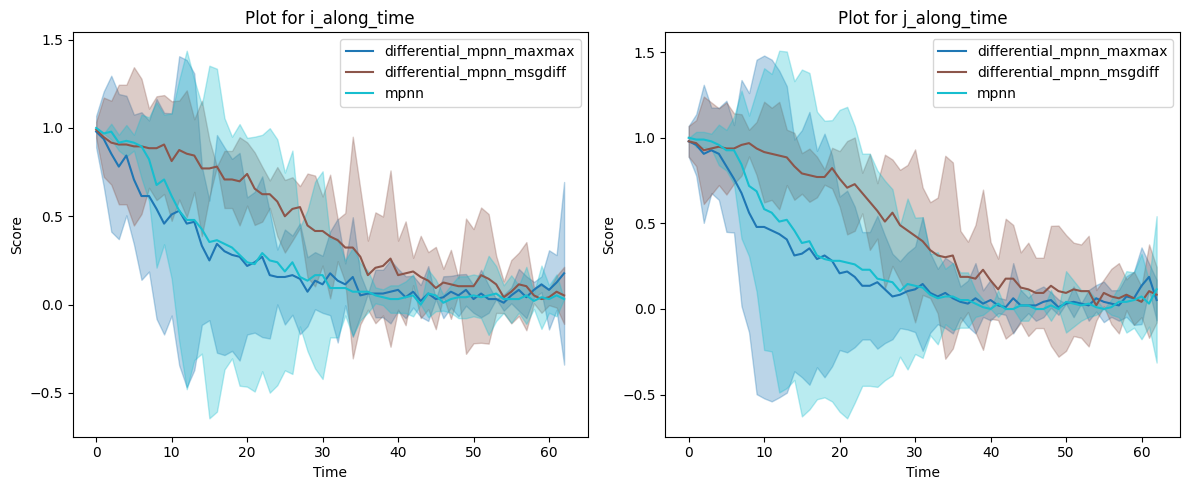

In [12]:
def plot_hints(df, algorithm, hints, ncols=2):
    """
    Plots the mean and 95% confidence interval for different hints in a dataframe grouped by processor type 
    and hint teacher forcing. The plots are arranged in subplots with two columns.

    Parameters:
    df (DataFrame): The input dataframe containing columns 'processor_type', 'hint_teacher_forcing', and hint values.
    hints (list of str): List of hints (column names) to plot.
    ncols (int): Number of columns for subplots (default is 2).
    """
    grouped = df.groupby(["processor_type", "hint_teacher_forcing"])
    num_hints = len(hints)
    nrows = (num_hints + ncols - 1) // ncols  # Compute required rows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows), sharex=True)
    axes = np.array(axes).reshape(nrows, ncols)  # Ensure axes is always a 2D array

    colors = plt.cm.get_cmap("tab10", len(grouped))  # Generate different colors for different models

    for idx, hint in enumerate(hints):
        row, col = divmod(idx, ncols)
        ax = axes[row, col]

        for model_idx, ((processor, hint_tf), group) in enumerate(grouped):
            arrays = np.stack(group[hint].to_numpy())  # Convert column to numpy array
            mean = np.mean(arrays, axis=0)
            std_err = stats.sem(arrays, axis=0, ddof=1)  # Standard error
            ci = std_err * stats.t.ppf(0.975, len(arrays) - 1)  # 95% confidence interval
            
            color = colors(model_idx)  # Assign unique color
            ax.plot(mean, label=f"{processor}", color=color)
            ax.fill_between(range(len(mean)), mean - ci, mean + ci, alpha=0.3, color=color)

        ylabel = "Mean square error" if hint in ["sum_along_time", "best_sum_along_time"] else "Score"
        ax.set_ylabel(ylabel)
        ax.set_xlabel("Time")
        ax.set_title(f"Plot for {hint}")
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_hints, nrows * ncols):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    fig.savefig(f"{algorithm}_hint_analysis.pdf", dpi=300)
    plt.show()


plot_hints(df_insertion, "insertion_sort", ["i_along_time", "j_along_time"])

/tmp/ipykernel_549534/4223518310.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(grouped))  # Generate different colors for different models


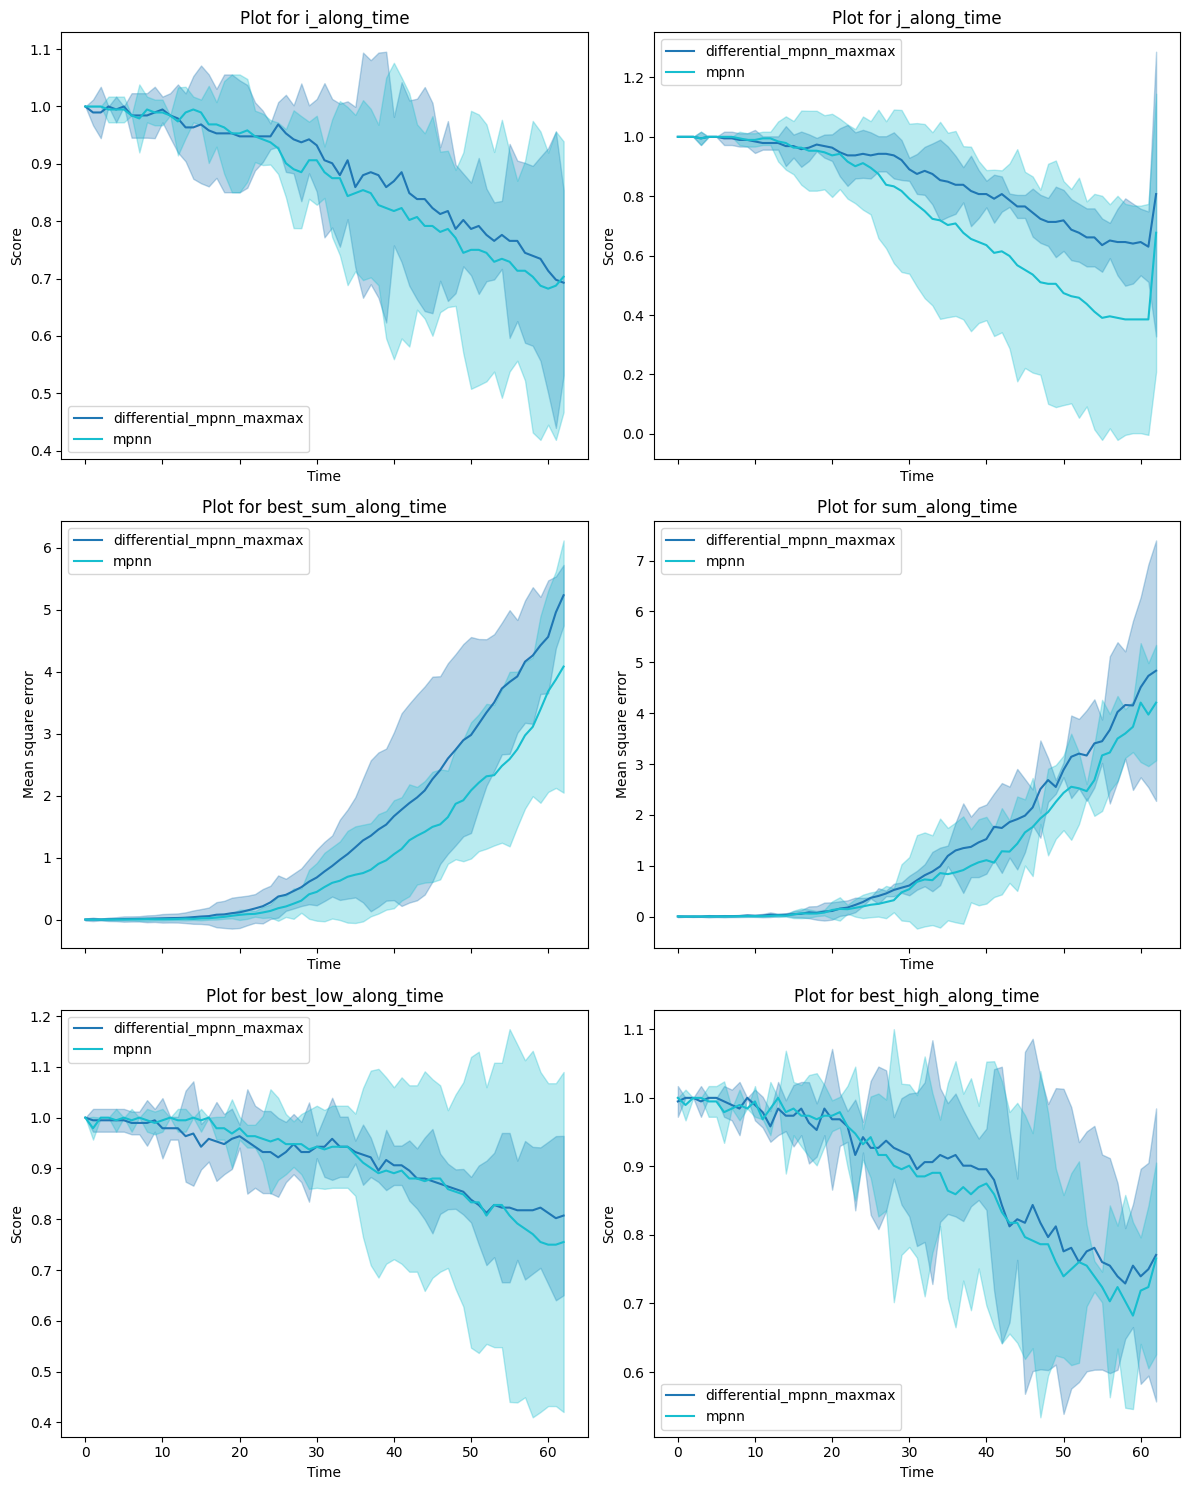

In [13]:
plot_hints(df_kadane, "kadane", hints_kadane)

## Get data from Wandb

In [32]:
def get_runs(entity="jccamml", project="L65-project", algorithm="find_maximum_subarray_kadane"):
    api = wandb.Api(timeout=30)
    wandb_filters = {
        #"config.algorithms": [algorithm],
        "created_at": {"$gt": "2025-03-22T01"}, # greater than
        #"state": "finished",
    }
    runs = api.runs(f"{entity}/{project}", filters=wandb_filters) 
    print(f"Found {len(runs)} runs.")
    data = {}
    for run in runs:
        if run.config['algorithms'] != [algorithm] or run.summary.get('_step',0) < 80000 or run.config['eval_every'] != 500:
            print(f"Skipping run {run.id} with algorithm {run.config['algorithms']} and steps {run.summary.get('_step',0)}")
            continue 
        
        if data.get((run.config['processor_type'], run.config['hint_teacher_forcing'], run.config['seed'])) is None:
            data[(run.config['processor_type'], run.config['hint_teacher_forcing'], run.config['seed'])]  = run

    return data

In [33]:
data_kadane = get_runs()
data_insertion = get_runs("biermann-carla-university-of-cambridge","L65-project", "insertion_sort")

print(f"Length Kadane {len(data_kadane)}")
print(f"Length Insertion {len(data_insertion)}")

Found 147 runs.
Skipping run mf2en0ra with algorithm ['bfs'] and steps 0
Skipping run f8aowemb with algorithm ['bfs'] and steps 1181
Skipping run wskeew1n with algorithm ['bfs'] and steps 0
Skipping run ah31c565 with algorithm ['bfs'] and steps 0
Skipping run nbxcff2v with algorithm ['bfs'] and steps 0
Skipping run wyl28e32 with algorithm ['bfs'] and steps 0
Skipping run c40nf94c with algorithm ['bfs'] and steps 0
Skipping run r0tdmrsk with algorithm ['bfs'] and steps 0
Skipping run l4hssvng with algorithm ['bfs'] and steps 2
Skipping run qv2dvuaj with algorithm ['bfs'] and steps 3
Skipping run 140lw5y2 with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run 6q5qu1tn with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run 7o8sf2j5 with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run chz6czcc with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run drsfg7y7 with algorithm ['find_maximum_subarray_kadane'] and steps 0
S

In [35]:
for c in sorted(data_kadane.keys()):
    print(c)

('differential_mpnn_maxmax', 0, 0)
('differential_mpnn_maxmax', 0, 1)
('differential_mpnn_maxmax', 0, 2)
('differential_mpnn_maxmax-ablate_outer', 0, 0)
('differential_mpnn_maxmax-ablate_outer', 0, 1)
('differential_mpnn_maxmax-ablate_outer', 0, 2)
('differential_mpnn_maxmax-ablate_subtract', 0, 0)
('differential_mpnn_maxmax-ablate_subtract', 0, 1)
('differential_mpnn_maxmax-ablate_subtract', 0, 2)
('differential_mpnn_maxmax-sum', 0, 0)
('differential_mpnn_maxmax-sum', 0, 1)
('differential_mpnn_maxmax-sum', 0, 2)
('differential_mpnn_msgdiff', 0, 0)
('differential_mpnn_msgdiff', 0, 1)
('differential_mpnn_msgdiff', 0, 2)
('mpnn', 0, 0)
('mpnn', 0, 1)
('mpnn', 0, 2)
('mpnn', 0.5, 0)
('mpnn', 0.5, 1)
('mpnn', 0.5, 2)


## Norms

In [14]:
# TODO

## Entropies

In [ ]:
# TODO

## Losses

In [ ]:
# Analysis - Kadane
cache = {}
algorithm = "find_maximum_subarray_kadane"
results = list()
for (name, run) in data_kadane.items():
    history_data = run.history(keys=[f'{algorithm}_loss', f'{algorithm}_output_loss']) 
    history_data = history_data[(history_data["_step"] <= 80000) & (history_data["_step"] % 500 == 0)]  # Keep only <= 80k steps
    if len(history_data) == 161:
        cache[name] = history_data

# TODO

## Previous code

In [ ]:


# Group data by processor type and hint teacher forcing
grouped = df.groupby(["processor_type", "hint_teacher_forcing"])

# Plot the results
fig, axes = plt.subplots(len(grouped), 2, figsize=(12, 5 * len(grouped)), sharex=True)
if len(grouped) == 1:
    axes = [axes]  # Ensure axes is always iterable

for idx, ((processor, hint_tf), group) in enumerate(grouped):
    # Compute stats for i_along_time
    i_arrays = group["i_along_time"].tolist()  # List of lists
    mean_i, ci_i = compute_stats(i_arrays)

    # Compute stats for j_along_time
    j_arrays = group["j_along_time"].tolist()  # List of lists
    mean_j, ci_j = compute_stats(j_arrays)

    # Plot i_along_time
    ax_i = axes[idx][0]
    ax_i.plot(mean_i, label="Mean i_along_time")
    ax_i.fill_between(range(len(mean_i)), mean_i - ci_i, mean_i + ci_i, alpha=0.3)
    ax_i.set_title(f"i_along_time - Processor: {processor}, HintTF: {hint_tf}")
    ax_i.set_ylabel("Value")
    ax_i.legend()

    # Plot j_along_time
    ax_j = axes[idx][1]
    ax_j.plot(mean_j, label="Mean j_along_time", color="orange")
    ax_j.fill_between(range(len(mean_j)), mean_j - ci_j, mean_j + ci_j, alpha=0.3, color="orange")
    ax_j.set_title(f"j_along_time - Processor: {processor}, HintTF: {hint_tf}")
    ax_j.set_ylabel("Value")
    ax_j.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()



In [ ]:
# Assign unique colors to each processor_type
processor_types = df_insertion["processor_type"].unique()
color_map = {proc: plt.get_cmap("tab10")(i) for i, proc in enumerate(processor_types)}

# Group data by hint_teacher_forcing first, then differentiate processor types
grouped = df_insertion.groupby(["hint_teacher_forcing"])

# Set up subplots (one row per hint_teacher_forcing, two columns for i and j)
fig, axes = plt.subplots(len(grouped), 2, figsize=(12, 5 * len(grouped)), sharex=True)

if len(grouped) == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one group

for idx, (hint_tf, group) in enumerate(grouped):
    ax_i, ax_j = axes[idx]

    for processor, sub_group in group.groupby("processor_type"):
        # Extract data
        i_arrays = np.stack(sub_group["i_along_time"].values)
        j_arrays = np.stack(sub_group["j_along_time"].values)

        x_vals = np.array(range(1, 64))

        # Compute stats
        mean_i, ci_i = compute_stats(i_arrays)
        mean_j, ci_j = compute_stats(j_arrays)

        # Pick color for this processor type
        color = color_map[processor]

        # Plot i_along_time
        ax_i.plot(x_vals, mean_i, label=f"{processor}", color=color)
        ax_i.fill_between(range(len(mean_i)), mean_i - ci_i, mean_i + ci_i, alpha=0.2, color=color)

        # Plot j_along_time
        ax_j.plot(x_vals, mean_j, label=f"{processor}", color=color)
        ax_j.fill_between(range(len(mean_j)), mean_j - ci_j, mean_j + ci_j, alpha=0.2, color=color)

    # Set labels and legends
    ax_i.set_title(f"Hint i")
    ax_i.set_ylabel("Score")
    ax_i.legend(title="Processor Type")

    ax_j.set_title(f"Hint j")
    ax_j.set_ylabel("Score")
    ax_j.legend(title="Processor Type")

plt.xlabel("Trajectory steps")
plt.tight_layout()
plt.show()

